<a href="https://colab.research.google.com/github/X-Xin6/DeLIVR/blob/main/Copy_of_DeliVR_test3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def standardize_data(X):
    """
    Standardize the dataset X.
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

# Simulate data for two-stage experiment
def generate_data(IV, beta, true_g, gamma, seed = 0):
	#seed for reproducibility
	if seed is None:
		seed = np.random.randint(0,2**32 - 1)
	np.random.seed(seed)
 #select 10% for first-stage sample
	s1_size = IV.shape[0]//10
	#The indices for stage 1 and stage 2
	s1_idx = np.random.choice(np.arange(IV.shape[0]), size = s1_size, replace = False)
	s2_idx = np.array(list(set(np.arange(IV.shape[0])).difference(s1_idx)))
	# stage 1 data and stage2 data
	s1_IV = IV[s1_idx,:]
	s2_IV = IV[s2_idx,:]
	#X=z*beta + error 1
	s1_expr = (s1_IV@beta).squeeze() + np.random.normal(size = s1_size)
	s1_expr = s1_expr.reshape(-1,1)
 # The Correlation Representing Confounding
	e = np.random.multivariate_normal(mean = [0,0], cov = [[1,gamma],[gamma,1]], size = s2_IV.shape[0])
  #s2_expr=s2_IV⋅β+e:,0 X=Z*beta+U
	s2_expr = (s2_IV@beta).squeeze() + e[:,0]
	#Y=s2_pheno=true_g(s2_expr)+e:,1 Y=g(X)+U
	s2_pheno = true_g(s2_expr) + e[:,1]
	s2_expr = s2_expr.reshape(-1,1)

	return s1_IV, s1_expr, s2_IV, s2_pheno,s2_expr

In [2]:
def fit_stage1(s1_IV, s1_expr, IV):
    design = sm.add_constant(s1_IV)
    #we find the estimated beta by fitting stage1 model
    stage1 = sm.OLS(s1_expr, design).fit()
    print(stage1.summary())
    #true beta
    #print(stage1.params)
    s2_design = sm.add_constant(IV)
    # we estimate X by plugging the stage 2 data. s2_expr=s2_IV⋅β_hat; X_hat=Z*beta_hat
    s2_expr = stage1.predict(s2_design).reshape(-1, 1)
    # we plot the relationship between s2_expr and s2_pheno.
    return s2_expr,stage1.params

In [3]:
import torch
from torch import nn

class Stage2Model(nn.Module):
    def __init__(self):
        super(Stage2Model, self).__init__()

        # Define the first part of the network
        self.dense1 = nn.Linear(in_features=1, out_features=8)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(in_features=8, out_features=8)
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(in_features=8, out_features=1)

        # Define the skip connection
        self.skip_dense = nn.Linear(in_features=1, out_features=1)

    def forward(self, x):
        # Forward pass through the first part of the network
        x1 = self.dense1(x)
        x1 = self.relu1(x1)
        x1 = self.dense2(x1)
        x1 = self.relu2(x1)
        x1 = self.dense3(x1)

        # Forward pass through the skip connection
        skip_out = self.skip_dense(x)

        # Add the output of the skip connection to the main network's output
        x1 += skip_out

        return x1




In [4]:
def sample_split(expr, pheno, test_ratio, val_ratio, seed=None):
    if seed is None:
        seed = np.random.randint(0, 2**32 - 1)

    # Split the data into training and validation + test sets
    expr_train, expr_temp, pheno_train, pheno_temp = train_test_split(expr, pheno, test_size=val_ratio + test_ratio, random_state=seed)

    # Calculate the proportion of the test set relative to the combined validation and test sets
    test_ratio_adjusted = test_ratio / (val_ratio + test_ratio)

    # Split the validation + test sets into separate validation and test sets
    expr_val, expr_test, pheno_val, pheno_test = train_test_split(expr_temp, pheno_temp, test_size=test_ratio_adjusted, random_state=seed)

    return expr_train, expr_val, expr_test, pheno_train, pheno_val, pheno_test


import torch.optim as optim

def train_stage2(model, X_train, y_train, X_val, y_val, epochs, learning_rate,weight_decay):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    train_losses, val_losses = [], []

    # Reshape the input tensors to have two dimensions: [batch_size, num_features]
    X_train = X_train.view(-1, 1) if len(X_train.shape) == 1 else X_train
    X_val = X_val.view(-1, 1) if len(X_val.shape) == 1 else X_val

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())

        if epoch % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}")

    return train_losses, val_losses


Stage1_Test: Compare the predicted X and true X

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     264.5
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          2.55e-298
Time:                        21:14:45   Log-Likelihood:                -1427.5
No. Observations:                1000   AIC:                             2881.
Df Residuals:                     987   BIC:                             2945.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--

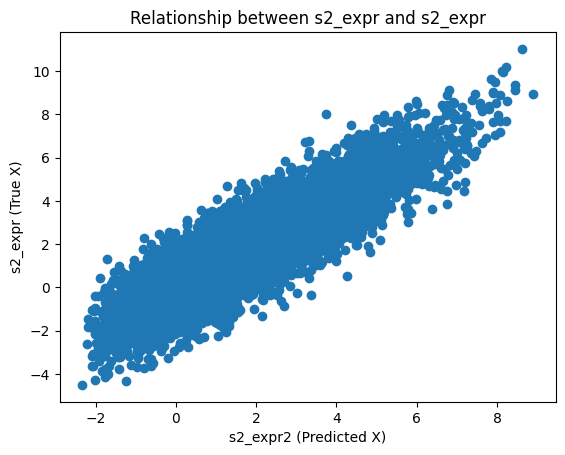

In [5]:
    import torch
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm
    from sklearn.model_selection import train_test_split
    from torch import nn, optim
    #data simulation test
    #Data Simulation
    # Load data
    from google.colab import drive
    drive.mount("/content/drive")

    simulated_IV = pd.read_csv('/content/drive/MyDrive/colab_data/simulated_IV.txt', sep=' ',header=None).values
    s1_beta = pd.read_csv('/content/drive/MyDrive/colab_data/s1_beta.txt', sep=' ',header=None).values.squeeze()
    true_g = lambda x: 3 * x ** 2
    gamma = 0.7
    #here simulated_IV represent Z, s1_beta represent beta. We generate X with X= Z*beta+U+error1
    #s1_IV, s1_expr, s2_IV, s2_pheno = generate_data(simulated_IV, s1_beta, true_g, gamma)
    s1_IV, s1_expr, s2_IV, s2_pheno,s2_expr = generate_data(simulated_IV, s1_beta, true_g, gamma)
    #standardize true Z,X,,and Y or only training data?
    '''
    s1_IV_std=standardize_data(s1_IV)
    s1_expr_std=standardize_data(s1_expr)
    s2_IV_std=standardize_data(s2_IV)
    s2_pheno_std=standardize_data(s2_pheno)
    #train with standardized data
    s2_expr2_std,stage1_params = fit_stage1(s1_IV_std, s1_expr_std, s2_IV_std)
    '''
    #train with non-standardized data
    s2_expr2,stage1_params = fit_stage1(s1_IV, s1_expr, s2_IV)

    print(stage1_params)
    print(stage1_params[1])
    # Plot the printgenerated IVs (X) against the fitted values from stage 1
    import matplotlib.pyplot as plt
    import numpy as np
    plt.scatter(s2_expr2, s2_expr)
    #plot std data
    #plt.scatter(s2_expr2_std, s2_expr)
    plt.xlabel('s2_expr2 (Predicted X)')
    plt.ylabel('s2_expr (True X)')
    plt.title('Relationship between s2_expr and s2_expr')
    plt.show()


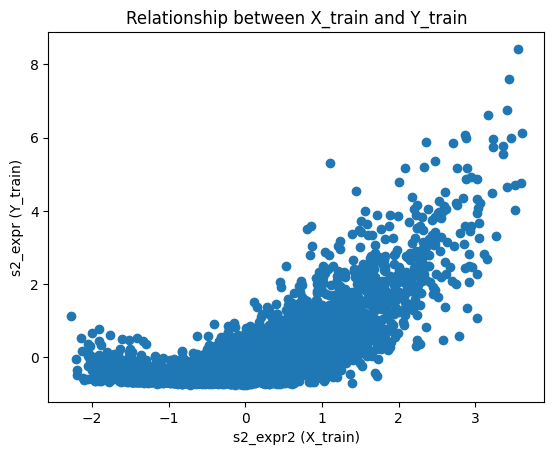

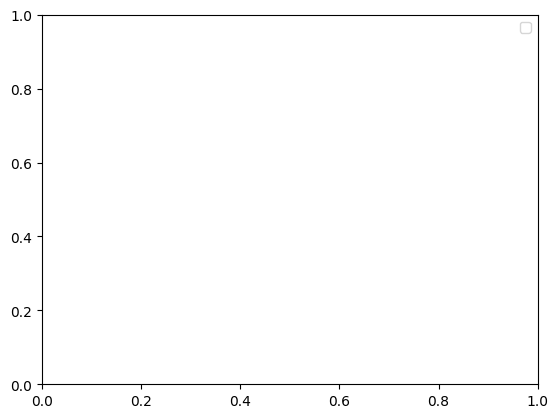

In [7]:
    test_ratio = 0.4
    val_ratio = 0.1
    #train with std data
    #expr_train, expr_val, expr_test, pheno_train, pheno_val, pheno_test = sample_split(s2_expr2_std, s2_pheno_std, test_ratio, val_ratio)
    #train with non-std data

    #expr_train, expr_val, expr_test, pheno_train, pheno_val, pheno_test = sample_split(s2_expr2, s2_pheno, test_ratio, val_ratio)
    #only standardize s2_expr2, s2_pheno
    s2_pheno_std=standardize_data(s2_pheno)
    s2_expr2_std=standardize_data(s2_expr2)

    #split data into training/valid/ test data
    expr_train, expr_val, expr_test, pheno_train, pheno_val, pheno_test = sample_split(s2_expr2_std, s2_pheno_std, test_ratio, val_ratio)
    #convert ttraining/valid/ test data into tensor
    expr_train_tensor = torch.tensor(expr_train, dtype=torch.float32)
    expr_val_tensor = torch.tensor(expr_val, dtype=torch.float32)
    expr_test_tensor = torch.tensor(expr_test, dtype=torch.float32)
    pheno_train_tensor = torch.tensor(pheno_train, dtype=torch.float32)
    pheno_val_tensor = torch.tensor(pheno_val, dtype=torch.float32)
    pheno_test_tensor = torch.tensor(pheno_test, dtype=torch.float32)
    import matplotlib.pyplot as plt
    plt.scatter(expr_train_tensor.numpy(), pheno_train_tensor.numpy())
    #plot std data
    #plt.scatter(s2_expr2_std, s2_expr)
    plt.xlabel('s2_expr2 (X_train)')
    plt.ylabel('s2_expr (Y_train)')
    plt.title('Relationship between X_train and Y_train')
    plt.show()

In [8]:
    stage2_model = Stage2Model()
# Assuming 'train_losses' and 'val_losses' are obtained from the training function
    train_losses, val_losses = train_stage2(stage2_model, expr_train_tensor, pheno_train_tensor,expr_val_tensor,  pheno_val_tensor,  epochs=3000, learning_rate=0.001,weight_decay=0.01)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4500])) that is different to the input size (torch.Size([4500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([900])) that is different to the input size (torch.Size([900, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/3000, Train Loss: 1.7187786102294922, Val Loss: 1.7364329099655151
Epoch 51/3000, Train Loss: 1.2612875699996948, Val Loss: 1.2725075483322144
Epoch 101/3000, Train Loss: 1.0542181730270386, Val Loss: 1.0609506368637085
Epoch 151/3000, Train Loss: 1.0097516775131226, Val Loss: 1.0139917135238647
Epoch 201/3000, Train Loss: 0.9997743964195251, Val Loss: 1.0033533573150635
Epoch 251/3000, Train Loss: 0.9950090050697327, Val Loss: 0.998571515083313
Epoch 301/3000, Train Loss: 0.9924560785293579, Val Loss: 0.9960416555404663
Epoch 351/3000, Train Loss: 0.9910966753959656, Val Loss: 0.9946902990341187
Epoch 401/3000, Train Loss: 0.9903789758682251, Val Loss: 0.9939670562744141
Epoch 451/3000, Train Loss: 0.9899984002113342, Val Loss: 0.9935754537582397
Epoch 501/3000, Train Loss: 0.989788830280304, Val Loss: 0.9933504462242126
Epoch 551/3000, Train Loss: 0.9896337985992432, Val Loss: 0.993145227432251
Epoch 601/3000, Train Loss: 0.9895448088645935, Val Loss: 0.9930518269538879
Epoch

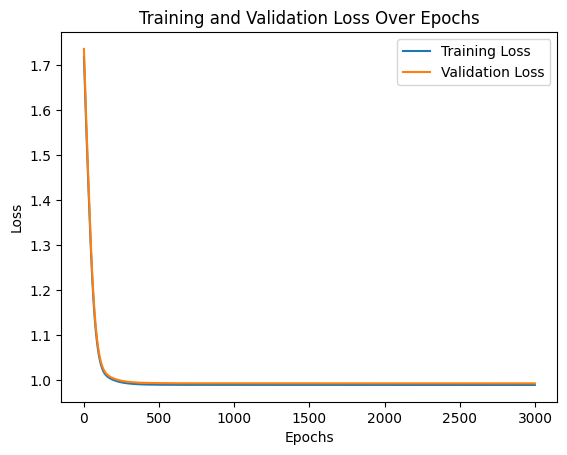

In [9]:
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

In [10]:
for para in stage2_model.parameters():
  print(para)

Parameter containing:
tensor([[ 6.2034e-03],
        [ 1.6297e-02],
        [-7.4170e-03],
        [ 1.2690e-41],
        [ 1.0212e-01],
        [ 2.8178e-03],
        [ 8.5285e-03],
        [-4.9054e-04]], requires_grad=True)
Parameter containing:
tensor([ 1.7637e-01, -8.7054e-03, -4.2338e-03, -2.7621e-08,  4.3665e-02,
         7.0052e-02,  2.1871e-01, -3.2772e-04], requires_grad=True)
Parameter containing:
tensor([[ 8.0156e-02,  3.3101e-04, -1.2197e-02,  1.5375e-29,  1.6952e-02,
          1.2602e-02,  9.5450e-02, -2.4124e-05],
        [ 2.9058e-13, -8.3475e-14,  3.1318e-15, -3.7525e-41, -2.3439e-12,
          3.8391e-13,  1.8271e-12,  2.5718e-15],
        [ 1.0924e-01,  1.7043e-03,  5.2012e-03, -3.2125e-41,  7.7067e-02,
          1.5928e-01,  1.5809e-01, -7.0375e-04],
        [ 1.7913e-01, -2.7772e-03, -1.0852e-02,  1.9789e-41,  3.2292e-02,
         -1.4215e-02,  1.0807e-01, -4.6728e-05],
        [ 1.2770e-02, -9.8992e-07,  4.6333e-41,  4.5595e-41, -1.7850e-03,
          1.6928e-02, 

In [11]:
for index, item in enumerate(stage2_model.parameters(),start=0):
  print(index,item.shape)

0 torch.Size([8, 1])
1 torch.Size([8])
2 torch.Size([8, 8])
3 torch.Size([8])
4 torch.Size([1, 8])
5 torch.Size([1])
6 torch.Size([1, 1])
7 torch.Size([1])


MSE: 1.0144084692001343, RMSE: 1.0071784257888794, MAE: 0.6701866388320923


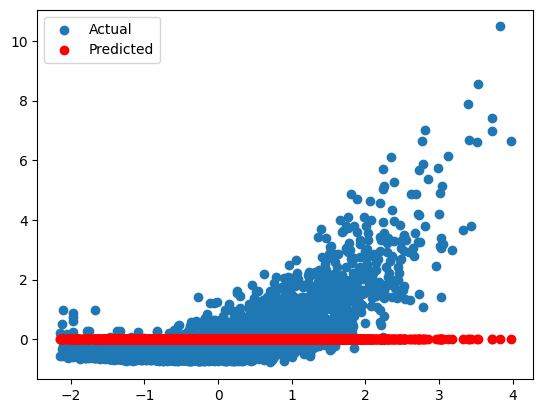

array([-0.19254512,  0.25317022, -0.5745632 , ..., -0.5895858 ,
       -0.4516    , -0.06107657], dtype=float32)

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming expr_test_tensor and pheno_test_tensor are your test datasets

# Make predictions
stage2_model.eval()
with torch.no_grad():
    predictions = stage2_model(expr_test_tensor).squeeze()

# Convert predictions and actual values to NumPy for evaluation
predictions_np = predictions.numpy()
actual_np = pheno_test_tensor.numpy()

# Calculate MSE and other metrics
mse = np.mean((predictions_np - actual_np) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions_np - actual_np))

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")

# Plot predictions vs actual values
plt.scatter(expr_test_tensor.numpy(), actual_np, label="Actual")
plt.scatter(expr_test_tensor.numpy(), predictions_np, label="Predicted", color="r")
plt.legend()
plt.show()

actual_np



In [20]:
stage2_model(tensor([4]))

NameError: ignored

In [13]:
actual_np

array([-0.19254512,  0.25317022, -0.5745632 , ..., -0.5895858 ,
       -0.4516    , -0.06107657], dtype=float32)

In [14]:
np.shape(expr_train_tensor.numpy())

(4500, 1)

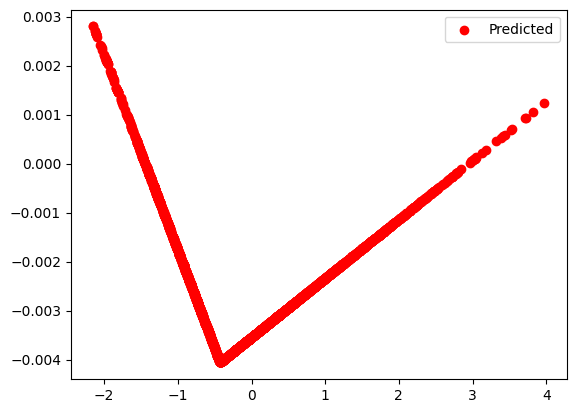

In [22]:
# Make predictions
stage2_model.eval()
with torch.no_grad():
    predictions2 = stage2_model(expr_test_tensor).squeeze()

# Convert predictions and actual values to NumPy for evaluation
predictions_np = predictions2.numpy()
actual_np = pheno_test_tensor.numpy()
#plt.scatter(expr_train_tensor.numpy(), actual_np, label="Actual")
plt.scatter(expr_test_tensor.numpy(), predictions_np, label="Predicted", color="r")
plt.legend()
plt.show()

In [21]:
expr_train_tensor

tensor([[-0.7143],
        [ 0.4497],
        [ 0.5941],
        ...,
        [-0.2476],
        [ 0.2867],
        [-1.2747]])

(13,)
(12,)
[ 0.27517839  0.18263548 -0.79321968 -0.08878717  2.0781978  -0.15939997
  1.40723474 -0.12973277  0.8875571   0.14513531  0.8352857  -0.25879005]
[ 0.35172591  0.25       -0.7        -0.14433758  2.         -0.09950438
  1.5        -0.09533149  1.          0.13878764  0.8        -0.16879593]


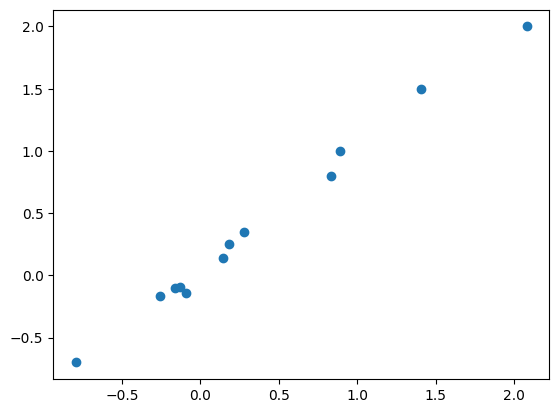

In [16]:
plt.scatter(stage1_params[1:],s1_beta)
print ((stage1_params).shape)
print((s1_beta).shape)
print(stage1_params[1:])
print(s1_beta)